In [ ]:
# STEP 1: Install dan import libraries
!pip install gdown joblib --quiet

import gdown
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# STEP 2: Download ZIP dari Google Drive
file_id = "1ZySw90rLIPI7cniKqxmRUKAHWZLt_isb"
output = "skin_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# STEP 3: Ekstrak ZIP
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(".")

# STEP 4: Path dataset
train_path = "skin-disease-dataset/train_set"
test_path = "skin-disease-dataset/test_set"


Downloading...
From: https://drive.google.com/uc?id=1ZySw90rLIPI7cniKqxmRUKAHWZLt_isb
To: /content/skin_dataset.zip
100%|██████████| 18.1M/18.1M [00:00<00:00, 96.2MB/s]



Classification Report:

                            precision    recall  f1-score   support

            BA- cellulitis       0.97      1.00      0.99        34
               BA-impetigo       1.00      0.95      0.97        20
           FU-athlete-foot       0.94      0.97      0.95        32
            FU-nail-fungus       0.94      0.97      0.96        33
               FU-ringworm       1.00      0.96      0.98        23
PA-cutaneous-larva-migrans       0.96      0.92      0.94        25
             VI-chickenpox       1.00      1.00      1.00        34
               VI-shingles       1.00      1.00      1.00        33

                  accuracy                           0.97       234
                 macro avg       0.98      0.97      0.97       234
              weighted avg       0.97      0.97      0.97       234



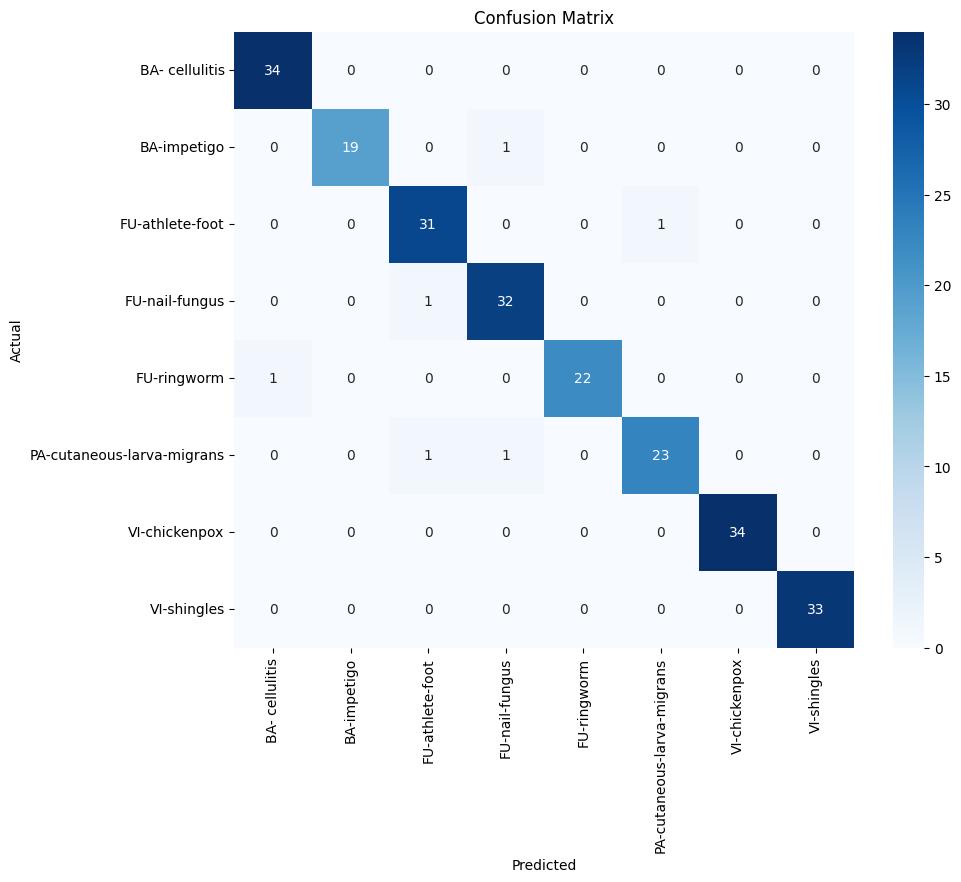

In [ ]:

# STEP 5: Load model CNN (MobileNetV2)
model_cnn = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# STEP 6: Fungsi ekstrak fitur
def extract_features(folder):
    features = []
    labels = []
    for label in os.listdir(folder):
        class_path = os.path.join(folder, label)
        if not os.path.isdir(class_path): continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                image = load_img(img_path, target_size=(224, 224))
                image = img_to_array(image)
                image = preprocess_input(image)
                image = np.expand_dims(image, axis=0)

                feature = model_cnn.predict(image, verbose=0)
                features.append(feature.flatten())
                labels.append(label)
            except:
                print(f"Skipped {img_path}")
    return np.array(features), np.array(labels)

# STEP 7: Ekstrak fitur dari train dan test
X_train, y_train = extract_features(train_path)
X_test, y_test = extract_features(test_path)

# STEP 8: Encode label
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# STEP 9: Train SVM dan evaluasi
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train_enc)
y_pred = clf.predict(X_test)

# STEP 10: Evaluasi model
print("\nClassification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# Confusion Matrix Plot
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


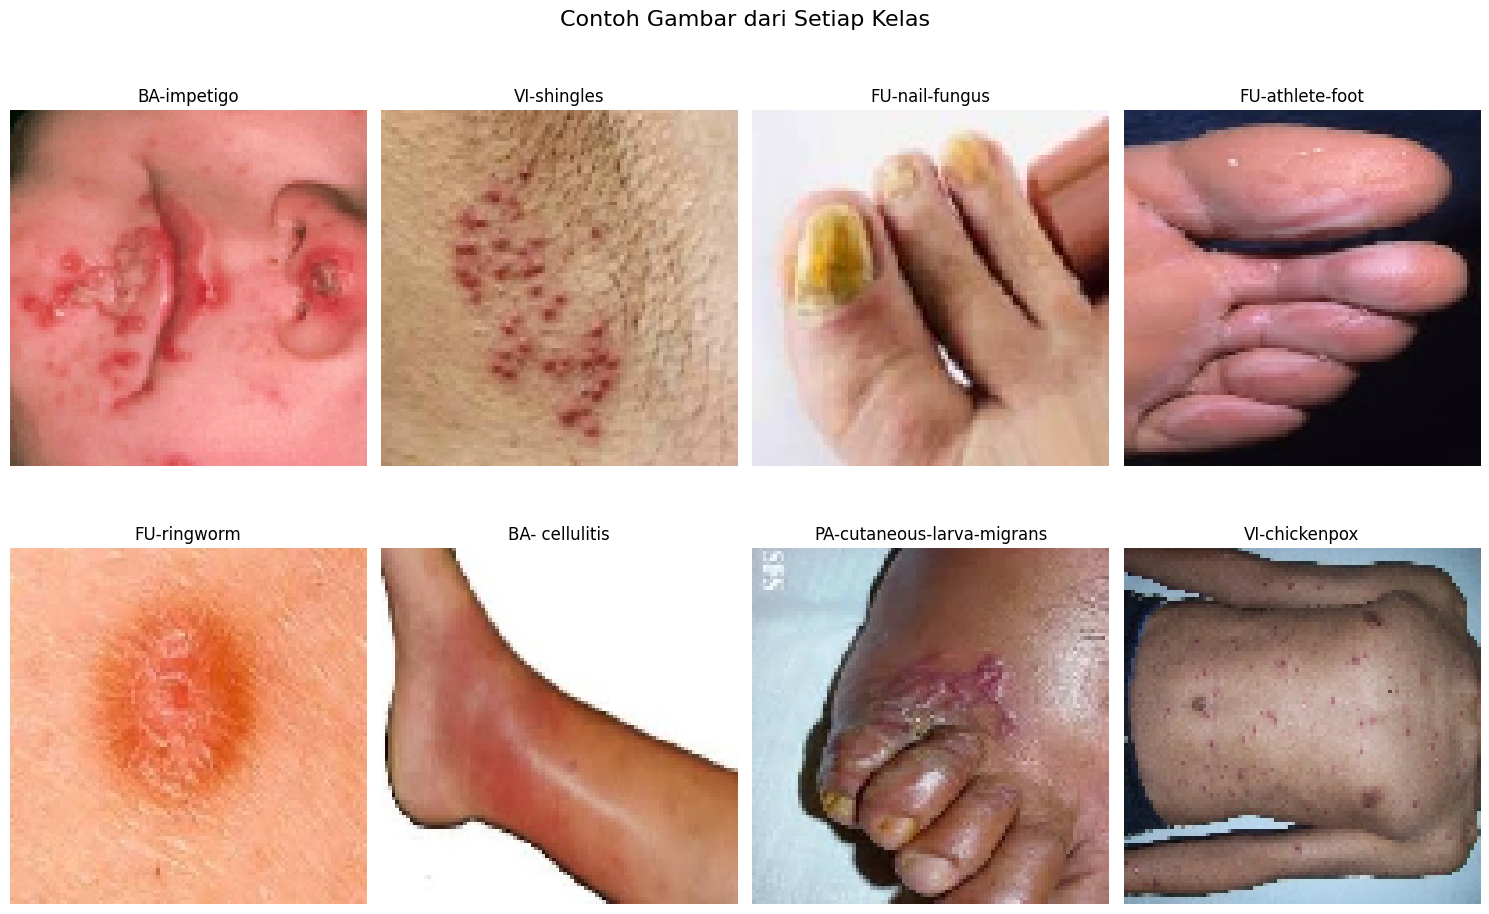

✅ Model dan encoder berhasil disimpan sebagai 'svm_skin_model.pkl' dan 'label_encoder.pkl'.


In [ ]:

# STEP 11: Tampilkan 1 gambar contoh per kelas dari test_set
import random
from PIL import Image

plt.figure(figsize=(15, 10))
label_dirs = os.listdir(test_path)
for idx, label in enumerate(label_dirs):
    label_folder = os.path.join(test_path, label)
    image_file = random.choice(os.listdir(label_folder))
    image_path = os.path.join(label_folder, image_file)
    img = load_img(image_path, target_size=(100, 100))
    plt.subplot(2, 4, idx+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.suptitle("Contoh Gambar dari Setiap Kelas", fontsize=16)
plt.tight_layout()
plt.show()

# STEP 12: Simpan model dan encoder
joblib.dump(clf, "svm_skin_model.pkl")
joblib.dump(le, "label_encoder.pkl")
print("✅ Model dan encoder berhasil disimpan sebagai 'svm_skin_model.pkl' dan 'label_encoder.pkl'.")

# STEP 13: Prediksi dari gambar input user
def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_arr = preprocess_input(img_to_array(img))
    img_arr = np.expand_dims(img_arr, axis=0)
    feature = model_cnn.predict(img_arr)
    pred = clf.predict(feature)
    class_name = le.inverse_transform(pred)[0]

    # Visualisasi gambar & hasil prediksi
    plt.imshow(load_img(image_path))
    plt.title(f"Prediksi: {class_name}")
    plt.axis("off")
    plt.show()

# Contoh penggunaan:
# predict_image("skin-disease-dataset/test_set/FU-ringworm/abc.jpg")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
import joblib  # Ganti dari pickle ke joblib

# Load model CNN (MobileNetV2)
model_cnn = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Load SVM dan Label Encoder dengan joblib
clf = joblib.load('svm_skin_model.pkl')
le = joblib.load('label_encoder.pkl')

def predict_image(image_path, threshold=50):
    img = load_img(image_path, target_size=(224, 224))
    img_arr = preprocess_input(img_to_array(img))
    img_arr = np.expand_dims(img_arr, axis=0)

    feature = model_cnn.predict(img_arr, verbose=0)
    probs = clf.predict_proba(feature)[0]
    pred = np.argmax(probs)
    class_name = le.inverse_transform([pred])[0]
    confidence = probs[pred] * 100

    if confidence < threshold:
        print("Gambar tidak relevan. Coba gambar lain.\n")
    else:
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"Prediksi: {class_name} ({confidence:.2f}%)")
        plt.show()



# Upload manual file dan prediksi
from google.colab import files
uploaded = files.upload()  # pilih file gambar dari komputer

for fname in uploaded.keys():
    predict_image(fname)
